# **Data Diri**
* Nama Lengkap: Chris Tianto Pratama
* Username: chrix0n
* Email: christiantopratama@gmail.com



---



# **Import**

In [ ]:
import os
import zipfile
import pandas as pd
import tensorflow as tf
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from google.colab import files
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from scipy import stats

# **Data Loading**

Link dataset: https://www.kaggle.com/datasets/mirichoi0218/insurance?datasetId=13720

In [ ]:
! pip install -q kaggle
files.upload() #Upload kaggle.json

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

# Download dataset
! kaggle datasets download -d mirichoi0218/insurance

  0% 0.00/16.0k [00:00<?, ?B/s]
100% 16.0k/16.0k [00:00<00:00, 12.6MB/s]


In [ ]:
local_zip = '/content/insurance.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
df = pd.read_csv('insurance.csv')

df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


# **Exploratory Data Analysis (EDA)**

# Deskripsi Variabel

| Nama fitur | Deskripsi | Tipe data |
|---|---|---|
|age| Umur pemegang polis asuransi kesehatan. |int64|
|sex| Jenis kelamin pemegang polis asuransi kesehatan. |object|
|bmi| Indeks massa tubuh pemegang polis asuransi kesehatan. |float64|
|children| Jumlah anak yang ditanggung oleh asuransi kesehatan. |int64|
|smoker| Menunjukkan apakah pemegang polis asuransi kesehatan merupakan perokok. |object|
|region| Daerah perumahan pemegang polis asuransi kesehatan di Amerika Serikat (northeast, southeast, southwest, northwest). |object|
|charges| Iuran atau premi asuransi kesehatan yang harus dibayar oleh pemegang polis asuransi. |float64 |


In [ ]:
# Informasi dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Pemeriksaan missing value

In [ ]:
age = (df.age < 0).sum()
bmi = (df.bmi <= 0).sum()
children = (df.children < 0).sum()
charges = (df.charges <= 0).sum()

print("Jumlah data dengan nilai di bawah 0 pada kolom age: ", age)
print("Jumlah data dengan nilai 0 atau di bawahnya pada kolom bmi: ", bmi)
print("Jumlah data dengan nilai di bawah 0 pada kolom children: ", children)
print("Jumlah data dengan nilai 0 atau di bawahnya pada kolom charges: ", charges)

Jumlah data dengan nilai di bawah 0 pada kolom age:  0
Jumlah data dengan nilai 0 atau di bawahnya pada kolom bmi:  0
Jumlah data dengan nilai di bawah 0 pada kolom children:  0
Jumlah data dengan nilai 0 atau di bawahnya pada kolom charges:  0


Tidak ada missing value, sehingga tidak ada data yang dihapus.

# Outlier Data

Visualisasi data dengan box plot untuk mendeteksi data outlier.

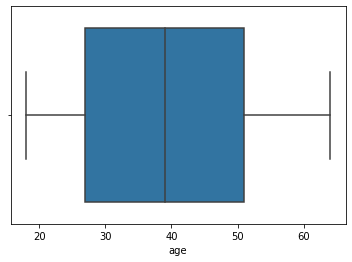

In [ ]:
sns.boxplot(x=df['age'])

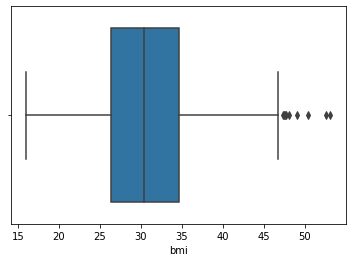

In [ ]:
sns.boxplot(x=df['bmi'])

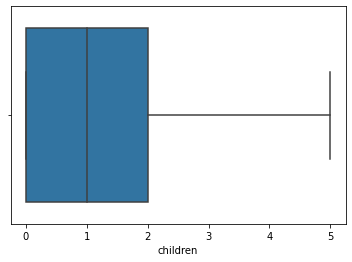

In [ ]:
sns.boxplot(x=df['children'])

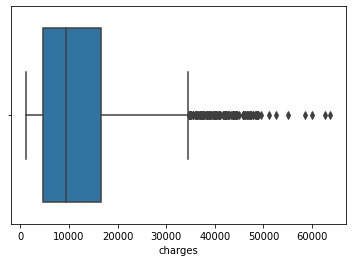

In [ ]:
sns.boxplot(x=df['charges'])

Terdapat data outlier pada fitur bmi dan charges, sehingga perlu dihapus untuk meningkatkan performa model. Pengidentifikasian data outlier dapat dilakukan dengan metode IQR.

In [ ]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df<(Q1-1.5*IQR))|(df>(Q3+1.5*IQR))).any(axis=1)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  after removing the cwd from sys.path.


In [ ]:
df.shape

(1193, 7)

Jumlah data berkurang menjadi 1193

# Univariate Analysis

In [ ]:
numerical_features = ['age', 'children', 'bmi', 'charges']
categorical_features = ['sex', 'smoker', 'region']

In [ ]:
sns.set()

**Analisis fitur kategori**

**Fitur sex**

        Jumlah data  Persentase
female          611        51.2
male            582        48.8


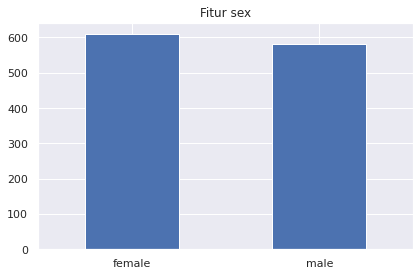

In [ ]:
feature = categorical_features[0]

counter = df[feature].value_counts()
percent = 100 * df[feature].value_counts(normalize=True)
temp = pd.DataFrame({'Jumlah data':counter, 'Persentase':percent.round(1)})
print(temp)

counter.plot(kind='bar', title="Fitur " + feature);

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Fitur sex terdiri atas dua kategori, yaitu male dan female. Grafik di atas menunjukkan bahwa jumlah data dengan jenis kelamin perempuan lebih banyak daripada laki-laki.

**Fitur smoker**

     Jumlah data  Persentase
no          1055        88.4
yes          138        11.6


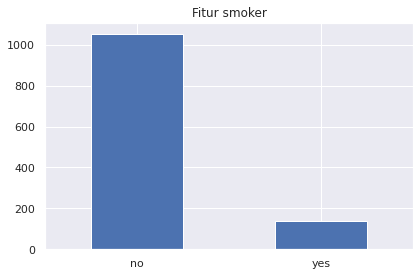

In [ ]:
feature = categorical_features[1]

counter = df[feature].value_counts()
percent = 100 * df[feature].value_counts(normalize=True)
temp = pd.DataFrame({'Jumlah data':counter, 'Persentase':percent.round(1)})
print(temp)

counter.plot(kind='bar', title="Fitur " + feature);
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Fitur smoker terdiri atas dua kategori, yaitu yes dan no. Dalam dataset ini, jumlah data untuk pemegang polis asuransi yang tidak merokok jauh lebih banyak daripada yang merokok.

**Fitur region**

           Jumlah data  Persentase
northwest          305        25.6
southeast          302        25.3
northeast          295        24.7
southwest          291        24.4


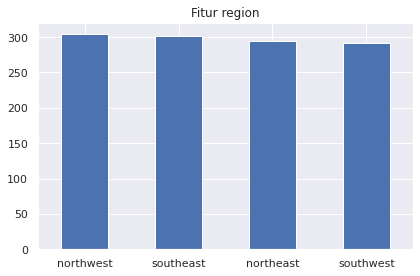

In [ ]:
feature = categorical_features[2]

counter = df[feature].value_counts()
percent = 100 * df[feature].value_counts(normalize=True)
temp = pd.DataFrame({'Jumlah data':counter, 'Persentase':percent.round(1)})
print(temp)

counter.plot(kind='bar', title="Fitur " + feature);
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Fitur region terdiri atas empat kategori, yaitu northwest, southeast, northeast, dan southwest. Keempat kategori teresbut memiliki jumlah data dengan persentase kurang lebih 25%. Di antara semua kategori pada fitur region, region northwest memiliki jumlah data tertinggi, sedangkan region southwest memiliki jumlah data terendah.

**Analisis fitur numerik**

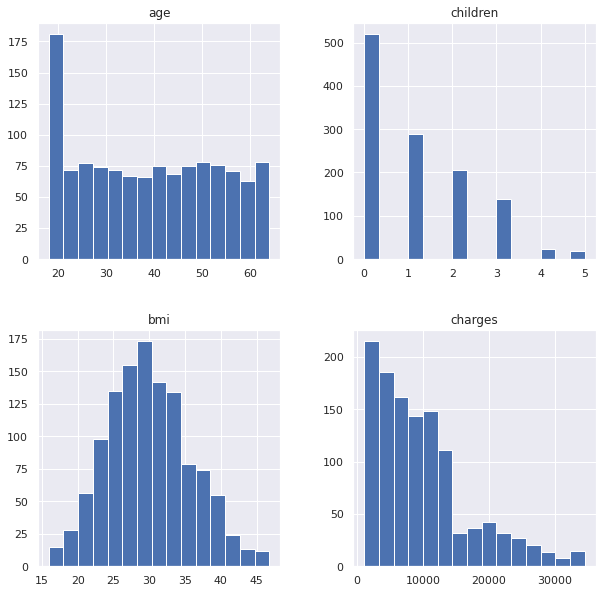

In [ ]:
df.hist(bins=15, column=numerical_features, figsize=(10,10))
plt.show()

- Distribusi nilai fitur charges bersifat miring ke kanan (right-skewed).
- Sebagian besar pemegang polis asuransi memiliki premi dari rentang 0 sampai 15000.
- Sebagian besar pemegang polis asuransi memiliki bmi sekitar 30.
- Jumlah data pemegang polis asuransi yang berumur 20 tahun merupakan yang terbanyak.
- Sebagian besar pemegang polis asuransi belum meiliki anak.

# Multivariate Analysis

https://www.kaggle.com/code/antoniosabatini/anemia-eda-max-accuracy-features-selection

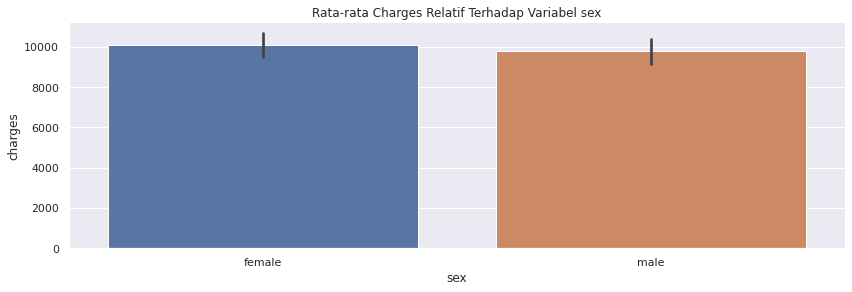

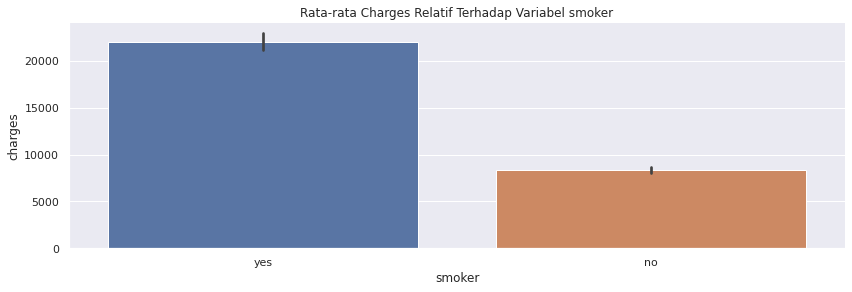

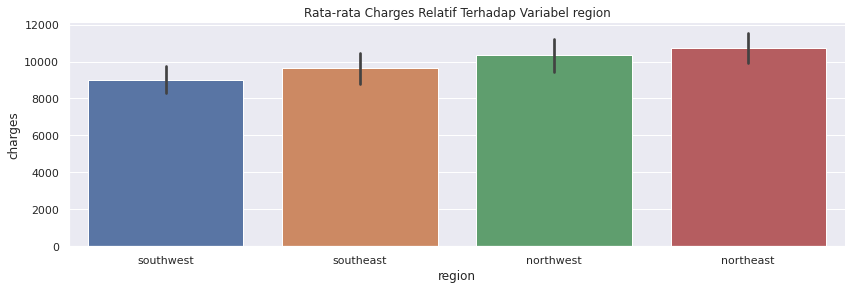

In [ ]:
for col in categorical_features:
  sns.catplot(x=col, y="charges", kind="bar", dodge=False, height = 4, aspect = 3,  data=df, palette="deep")
  plt.title("Rata-rata Charges Relatif Terhadap Variabel {}".format(col))

Grafik di atas menunjukkan bahwa:
- Jenis kelamin pemilik asuransi kesehatan tidak memiliki dampak yang besar terhadap biaya asuransi. Pada grafik biaya yang ditanggung oleh pemilik dengan jenis kelamin perempuan sedikit lebih besar daripada pemilik dengan jenis kelamin laki-laki.
- Pemilik asuransi yang merokok memiliki tagihan biaya asuransi yang lebih besar daripada pemilik asurasi yang tidak merokok.
- Pemilik asuransi yang berasal dari US bagian northeast memiliki biaya asuransi tertinggi, sedangkan bagian southwest memiliki biaya asuransi terendah.

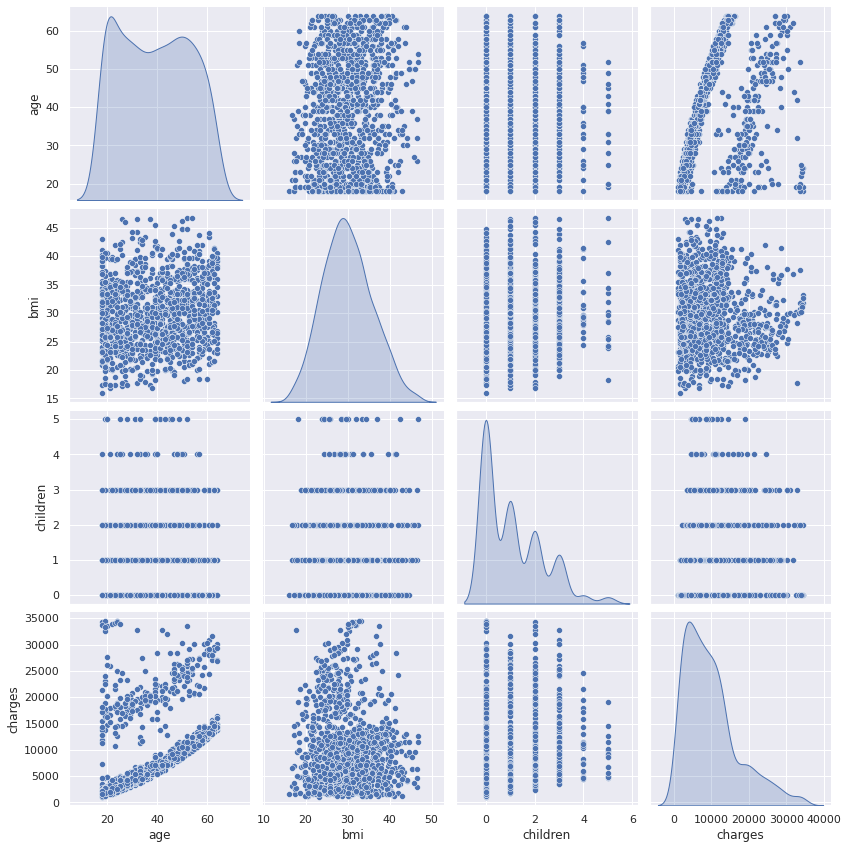

In [ ]:
sns.pairplot(df, diag_kind= 'kde', height=3)

Pairplot di atas menunjukkan bahwa:
- Biaya asuransi meningkat seiring dengan umur pemegang polis asuransi.
- Tidak terlihat hubungan atau kolerasi antara fitur *children* dan bmi dengan fitur *charges*.

**Mengukur skor kolerasi**

Text(0.5, 1.0, 'Correlation Matrix untuk Fitur Numerik ')

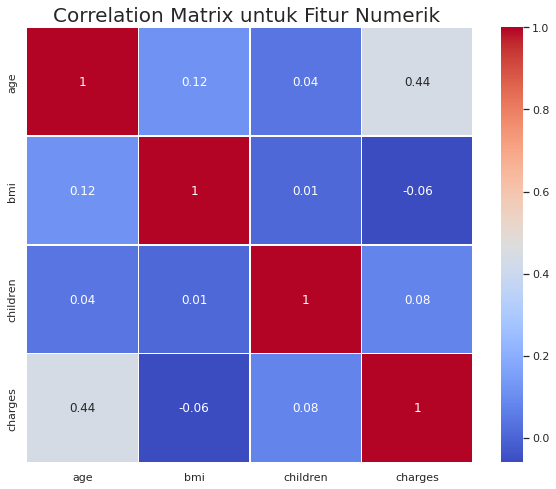

In [ ]:
correlation_matrix = df.corr().round(2)
plt.figure(figsize=(10, 8))
# Untuk menge-print nilai di dalam kotak, gunakan parameter anot=True
sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix untuk Fitur Numerik ", size=20)

Pada correlation matrix di atas terlihat bahwa terdapat kolerasi yang jelas antara fitur age dan fitur charges. 

Fitur bmi dan children memiliki kolerasi yang sangat rendah terhadap fitur charges (mendekati 0), sehingga kedua fitur tersebut dapat dihapus.

In [ ]:
df.drop(['bmi', 'children'], inplace=True, axis=1)
df.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,age,sex,smoker,region,charges
0,19,female,yes,southwest,16884.92400
1,18,male,no,southeast,1725.55230
2,28,male,no,southeast,4449.46200
3,33,male,no,northwest,21984.47061
4,32,male,no,northwest,3866.85520


# Data Preparation

Encoding fitur kategori dengan One-Hot Encoding

In [ ]:
df = pd.concat([df, pd.get_dummies(df['sex'], prefix='Sex')],axis=1)
df = pd.concat([df, pd.get_dummies(df['smoker'], prefix='Smoker')],axis=1)
df = pd.concat([df, pd.get_dummies(df['region'], prefix='Region')],axis=1)

In [ ]:
df.drop(['sex','smoker','region'], axis=1, inplace=True)

In [ ]:
df

,age,charges,Sex_female,Sex_male,Smoker_no,Smoker_yes,Region_northeast,Region_northwest,Region_southeast,Region_southwest
0,19,16884.92400,1,0,0,1,0,0,0,1
1,18,1725.55230,0,1,1,0,0,0,1,0
2,28,4449.46200,0,1,1,0,0,0,1,0
3,33,21984.47061,0,1,1,0,0,1,0,0
4,32,3866.85520,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
1333,50,10600.54830,0,1,1,0,0,1,0,0
1334,18,2205.98080,1,0,1,0,1,0,0,0
1335,18,1629.83350,1,0,1,0,0,0,1,0
1336,21,2007.94500,1,0,1,0,0,0,0,1


Fitur sex, smoker, dan region telah diubah menjadi kumpulan fitur dummy numerik.

# Train Test Split

Dataset dipisah menjadi 80% data training dan 20% data testing.

In [ ]:
from sklearn.model_selection import train_test_split
 
y = df["charges"]
x = df.drop(["charges"], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=66) #80% Train 20% Test

In [ ]:
print([len(x_train), len(y_train)])
print([len(x_test), len(y_test)])

[954, 954]
[239, 239]


In [ ]:
x_train

,age,Sex_female,Sex_male,Smoker_no,Smoker_yes,Region_northeast,Region_northwest,Region_southeast,Region_southwest
71,31,0,1,1,0,1,0,0,0
1286,28,1,0,1,0,1,0,0,0
809,25,0,1,1,0,1,0,0,0
226,28,0,1,1,0,0,0,1,0
105,20,0,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...
1282,18,1,0,0,1,1,0,0,0
62,64,0,1,1,0,0,1,0,0
710,18,0,1,1,0,0,0,1,0
928,62,1,0,1,0,0,0,1,0


In [ ]:
y_train

71       6799.45800
1286     3732.62510
809      3309.79260
226      2689.49540
105     17560.37975
           ...     
1282    14283.45940
62      30166.61817
710      1727.54000
928     13470.80440
1172    11093.62290
Name: charges, Length: 954, dtype: float64

# Standarisasi

Pada tahap ini dilakukan standarisasi terhadap fitur age data training dan data testing. Standarisasi dilakukan dengan metode StandardScaler dengan library ScikitLearn.

Data training

In [ ]:
scaler = StandardScaler()

s_train = x_train["age"].to_numpy().reshape(-1, 1)
scaler.fit(s_train)

x_train[["age"]]= scaler.transform(x_train[["age"]])
x_train["age"].head()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


71     -0.552698
1286   -0.765996
809    -0.979294
226    -0.765996
105    -1.334792
Name: age, dtype: float64

Data testing

In [ ]:
s_test = x_test["age"].to_numpy().reshape(-1, 1)
scaler.fit(s_test)

x_test[["age"]]= scaler.transform(x_test[["age"]])
x_test["age"].head()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


1332    0.870717
649     1.299350
399    -1.558204
341     1.585105
1185    0.370645
Name: age, dtype: float64

In [ ]:
x_train[["age"]].describe().round(4)

,age
count,954.0000
mean,-0.0000
std,1.0005
min,-1.4770
25%,-0.9082
50%,0.0161
75%,0.8693
max,1.7936


In [ ]:
x_test[["age"]].describe().round(4)

,age
count,239.0000
mean,0.0000
std,1.0021
min,-1.5582
25%,-0.8795
50%,0.0135
75%,0.8707
max,1.7280


# Model Development

Menentukan hyperparameter terbaik untuk setiap algoritma dengan Grid Search

In [ ]:
#List algo yang digunakan dengan parameter-parameter yang akan diuji
algo = {
        'KNN': {
            'model': KNeighborsRegressor(),
            'param': {
                'n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
                'weights': ['uniform', 'distance'],
                'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']
            }
        },
        'RandomForest': {
            'model': RandomForestRegressor(),
            'param': {
                'n_estimators': [5, 10, 25, 50, 75, 100],
                'max_depth' : [4, 8, 16, 32, 64, None],
                'random_state': [11, 22, 33, 44, 55],
                'min_samples_leaf': [1, 2, 4, 8, 16]
            }
        },
        'AdaBoost': {
            'model': AdaBoostRegressor(),
            'param': {
                'learning_rate' : [0.1, 0.05, 0.01, 0.005, 0.0015, 0.001],
                'n_estimators': [5, 10, 25, 50, 75, 100],
                'random_state': [11, 22, 33, 44, 55],
                'loss': ['linear', 'square', 'exponential']
            }
        },
        'GradientBoosting': {
            'model': GradientBoostingRegressor(),
            'param': {
                'learning_rate' : [0.1, 0.05, 0.01, 0.05, 0.0015, 0.001],
                'n_estimators': [5, 10, 25, 50, 75, 100],
                'max_depth': [3, 6, 12, 24, 48],
                'random_state': [11, 22, 33, 44, 55]
            }
        },
        'LGBM': {
            'model': LGBMRegressor(),
            'param': {
                'boosting_type' : ['gbdt', 'dart', 'goss', 'rf'],
                'learning_rate' : [0.1, 0.05, 0.01, 0.005, 0.0015, 0.001],
                'n_estimators': [5, 10, 25, 50, 75, 100],
                'random_state': [11, 22, 33, 44, 55],
            }
        }
    }

In [ ]:
res = []

for nama, prop in algo.items():
  grid =  GridSearchCV(prop['model'], prop['param'], cv=10, n_jobs = -1, return_train_score=False, verbose=2)
  grid.fit(x,y)
  res.append({
      'model': nama,
      'best_score': grid.best_score_,
      'best_params': grid.best_params_
  })

In [ ]:
pd.DataFrame(res,columns=['model','best_score','best_params'])

,model,best_score,best_params
0,KNN,0.422145,"{'algorithm': 'brute', 'n_neighbors': 9, 'weig..."
1,RandomForest,0.598057,"{'max_depth': 4, 'min_samples_leaf': 16, 'n_es..."
2,AdaBoost,0.590789,"{'learning_rate': 0.01, 'loss': 'exponential',..."
3,GradientBoosting,0.597659,"{'learning_rate': 0.05, 'max_depth': 3, 'n_est..."
4,LGBM,0.584571,"{'boosting_type': 'goss', 'learning_rate': 0.0..."


Parameter terbaik setiap algoritma digunakan dalam pelatihan model.

**K-Nearest Neighbor**

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
 
knn = KNeighborsRegressor(n_neighbors=9, algorithm='brute', weights='uniform')
knn.fit(x_train, y_train)

KNeighborsRegressor(algorithm='brute', n_neighbors=9)

**Random Forest**

In [ ]:
RF = RandomForestRegressor(n_estimators=25, max_depth=4, random_state=33, min_samples_leaf=16, n_jobs=-1)
RF.fit(x_train, y_train)     

RandomForestRegressor(max_depth=4, min_samples_leaf=16, n_estimators=25,
                      n_jobs=-1, random_state=33)

**AdaBoost**

In [ ]:
adaboost = AdaBoostRegressor(learning_rate=0.01, n_estimators=5, loss='exponential', random_state=22)                             
adaboost.fit(x_train, y_train)

AdaBoostRegressor(learning_rate=0.01, loss='exponential', n_estimators=5,
                  random_state=22)

**GradientBoosting**

In [ ]:
gb = GradientBoostingRegressor(learning_rate=0.05, max_depth=3, max_features='sqrt',
                               n_estimators=75, random_state=11, criterion='squared_error')
gb.fit(x_train, y_train)

GradientBoostingRegressor(criterion='squared_error', learning_rate=0.05,
                          max_features='sqrt', n_estimators=75,
                          random_state=11)

**LGBM Regressor**

In [ ]:
lgbm = LGBMRegressor(boosting_type='goss', learning_rate=0.05, n_estimators=50, random_state=44)
lgbm.fit(x_train, y_train)

LGBMRegressor(boosting_type='goss', learning_rate=0.05, n_estimators=50,
              random_state=44)

# Evaluasi Model

Evaluasi dilakukan dengan dua metrik, yaitu *Mean Squared Error* (MSE) dan *Mean Absolute Error* (MAE)

In [ ]:
mse = pd.DataFrame(columns=['MSE Train', 'MSE Test'])
mae = pd.DataFrame(columns=['MAE Train', 'MAE Test'])
model_dict = {'KNN': knn, 'RandomForest': RF, 'AdaBoost': adaboost, 'GradientBoosting':gb, 'LGBM':lgbm}
 
for name, model in model_dict.items():
    mse.loc[name, 'MSE Train'] = mean_squared_error(y_true=y_train, y_pred=model.predict(x_train))/1e3 
    mse.loc[name, 'MSE Test'] = mean_squared_error(y_true=y_test, y_pred=model.predict(x_test))/1e3
    mae.loc[name, 'MAE Train'] = mean_absolute_error(y_true=y_train, y_pred=model.predict(x_train))
    mae.loc[name, 'MAE Test'] = mean_absolute_error(y_true=y_test, y_pred=model.predict(x_test))

In [ ]:
mse

,MSE Train,MSE Test
KNN,19017.734499,23360.010408
RandomForest,20224.663778,20830.255662
AdaBoost,20841.928071,22319.002062
GradientBoosting,19686.417974,21444.284104
LGBM,18600.154909,22517.850226


In [ ]:
mae

,MAE Train,MAE Test
KNN,2544.131057,2545.618207
RandomForest,2605.814609,2447.991585
AdaBoost,2660.787667,2583.535004
GradientBoosting,2563.584108,2452.645954
LGBM,2520.122282,2457.882102


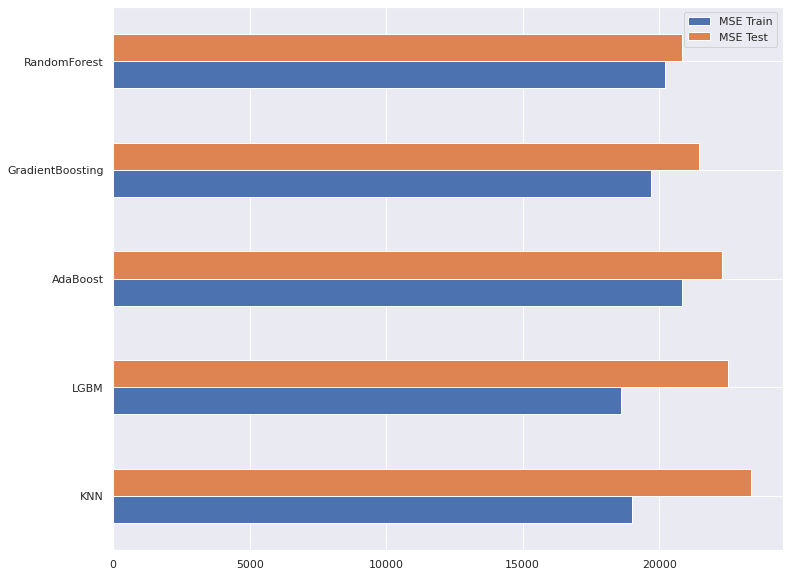

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
mse.sort_values(by='MSE Test', ascending=False).plot(kind='barh', ax=ax, zorder=3)
plt.legend(loc='upper right')
ax.grid(zorder=0)

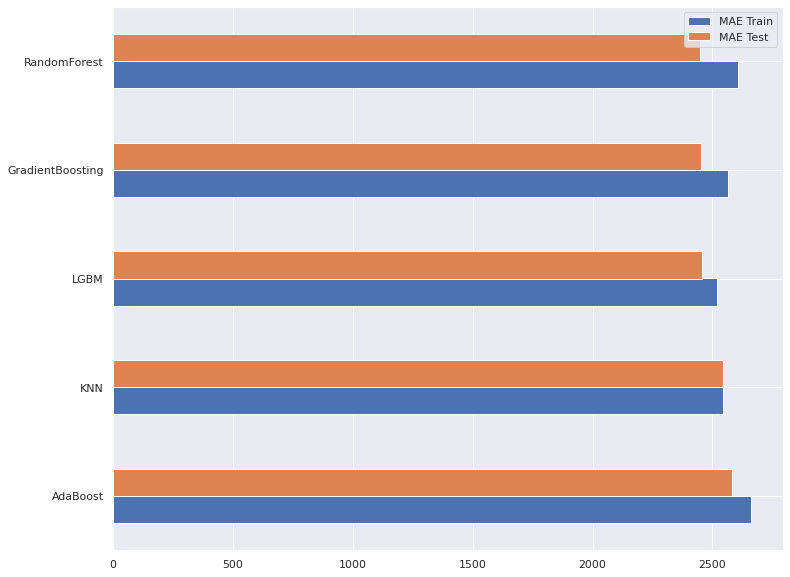

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
mae.sort_values(by='MAE Test', ascending=False).plot(kind='barh', ax=ax, zorder=3)
plt.legend(loc='upper right')
ax.grid(zorder=0)

Algoritma Random Forest memiliki nilai MSE dan MAE terendah dalam prediksi data testing.

**Uji prediksi**

In [ ]:
data = x_test.iloc[:1].copy()
pred_dict = {'y_true (nilai aktual)':y_test[:1]}
for name, model in model_dict.items():
    pred_dict['prediksi_'+name] = model.predict(data).round(1)
 
pd.DataFrame(pred_dict)

,y_true (nilai aktual),prediksi_KNN,prediksi_RandomForest,prediksi_AdaBoost,prediksi_GradientBoosting,prediksi_LGBM
1332,11411.685,10104.4,11277.9,11199.2,10379.3,10822.1


Algoritma Random Forest memberikan prediksi yang mendekati nilai aktual.